<a href="https://colab.research.google.com/github/cesar-claros/curso_ciencia_datos/blob/main/test2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/cesar-claros/curso_ciencia_datos.git
%cd curso_ciencia_datos/

Cloning into 'curso_ciencia_datos'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.
/content/curso_ciencia_datos


# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.cm import get_cmap

# 2. Load dataset

In [4]:
bienes_raices = pd.read_csv("ExaBienesRaices1.csv", sep=",")
bienes_raices

,ciudad,superficie,cuartos,baños,plazas_parking,piso,animales,amoblado,seguro,renta,impuesto,seguro_incendio,total
0,São Paulo,70,2,1,1,7,Si,Si,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,Si,No,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,Si,No,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,Si,No,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,No,No,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,Rio de Janeiro,470,4,5,3,1,Si,No,3772,6580,1650,85,12090
5342,Rio de Janeiro,140,3,3,1,1,Si,No,2285,2820,343,37,5485
5343,São Paulo,380,4,1,0,0,Si,No,0,2890,150,25,3065
5344,Porto Alegre,140,2,2,1,2,Si,Si,252,3000,150,44,3446


## Set all numeric data types to float32

In [5]:
df_not_str = bienes_raices.select_dtypes(exclude=object).astype("float32")
df_str = bienes_raices.select_dtypes(include=object)
df = df_not_str.join(df_str)
df = df.sort_values(by='ciudad') 

# 3. Exploration of raw data

## 3.1. Correlation of numerical atributes

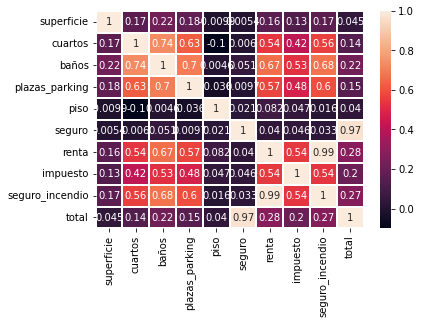

In [7]:
ax = sns.heatmap(df.corr(), annot=True, lw=1)

## 3.2. Histogram analysis

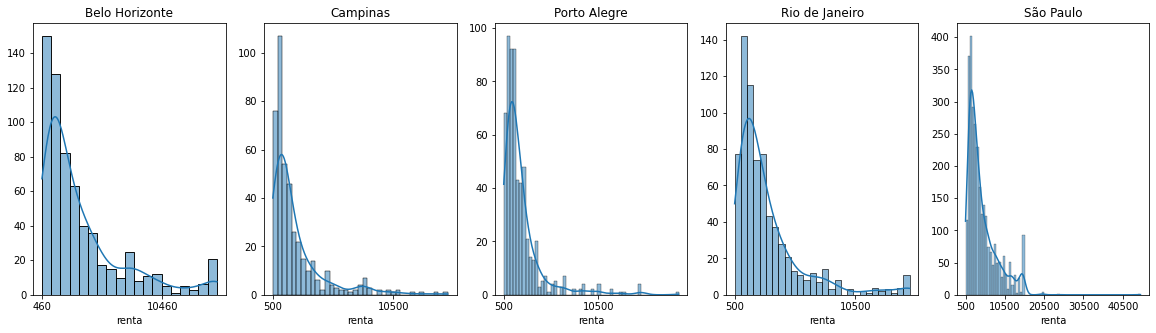

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
cities = df['ciudad'].unique()
i = 0
for city in cities:
    ax[i].set_title(city)
    city_name = df.loc[df['ciudad'] == city]
    sns.histplot(city_name['renta'], ax=ax[i], kde=True)
    ax[i].set_xticks(np.arange(city_name['renta'].min(), city_name['renta'].max(), step=10000))
    ax[i].set_ylabel('')
    i+=1

## 3.3. Boxplot analysis 

Text(0.5, 1.0, 'With outliers')

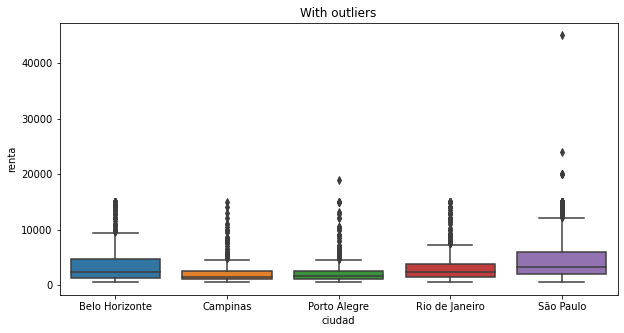

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.boxplot(x=df['ciudad'], y=df['renta'], ax=ax)
ax.set_title('With outliers')

# 4. Outlier removal


## 4.1. Inter-quartile criteria

In [10]:
# Grouping cities
ciudad_grupo = df.groupby('ciudad')['renta']
# Quantile 1 = 25% of data
Q1 = ciudad_grupo.quantile(.25)
Q3 = ciudad_grupo.quantile(.75)
# IQR
IQR = Q3 - Q1
# bounds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

In [11]:
# DataFrame to store the new data
new_data_IQ = pd.DataFrame()

for city in ciudad_grupo.groups.keys():
    is_city = df['ciudad'] == city
    accepted_limit = ((df['renta'] >= lower[city]) &
                     (df['renta'] <= upper[city]))
    
    select = is_city & accepted_limit
    data_select = df[select]
    new_data_IQ = pd.concat([new_data_IQ, data_select])
new_data_IQ = new_data_IQ.sort_values(by='ciudad') 
new_data_IQ.reset_index(inplace=True)

Text(0.5, 0.98, 'Histogram analysis after outlier removal with IQ criteria')

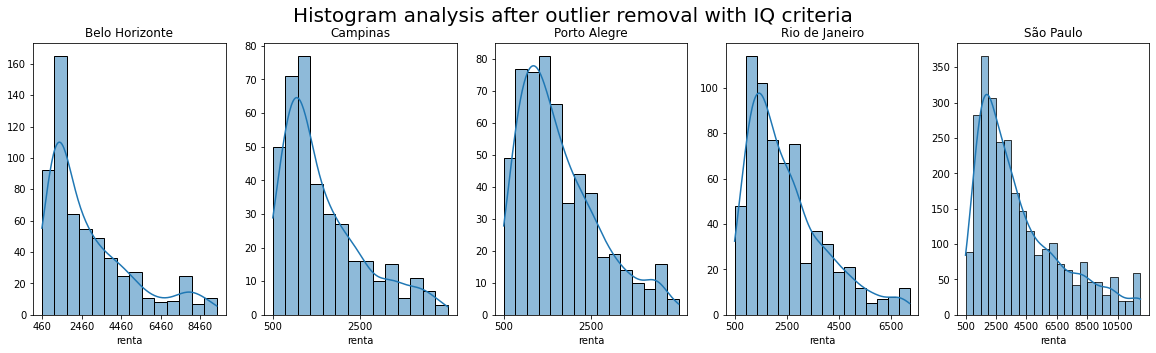

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
cities = new_data_IQ['ciudad'].unique()
i = 0
for city in cities:
    ax[i].set_title(city)
    city_name = new_data_IQ.loc[new_data_IQ['ciudad'] == city]
    sns.histplot(city_name['renta'], ax=ax[i], kde=True)
    ax[i].set_xticks(np.arange(city_name['renta'].min(), city_name['renta'].max(), step=2000))
    ax[i].set_ylabel('')
    i+=1
fig.suptitle('Histogram analysis after outlier removal with IQ criteria', fontsize=20)

Text(0.5, 0.98, 'Boxplot analysis after outlier removal with IQ criteria')

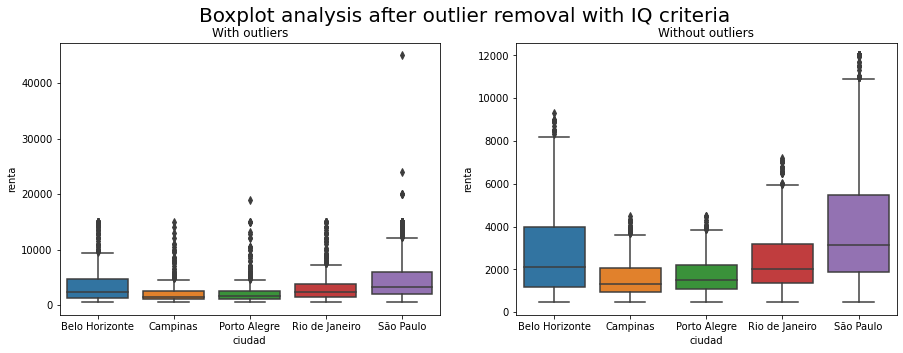

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.boxplot(x=df['ciudad'], y=df['renta'], ax=ax[0])
ax[0].set_title('With outliers')
sns.boxplot(x=new_data_IQ['ciudad'], y=new_data_IQ['renta'], ax=ax[1])
ax[1].set_title('Without outliers')
fig.suptitle('Boxplot analysis after outlier removal with IQ criteria', fontsize=20)

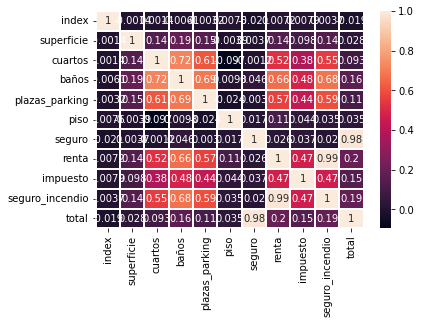

In [15]:
ax = sns.heatmap(new_data_IQ.corr(), annot=True, lw=1)

## 4.2. Z-score criteria

In [16]:
# DataFrame to store the new data
new_data_Z = pd.DataFrame()
Z_score = 2
for city in cities:
    df_temp_num = df_not_str.loc[df['ciudad'] == city]
    df_temp_num = df_temp_num[(np.abs(stats.zscore(df_temp_num))<Z_score).all(axis=1)]
    df_temp_str = df_str.loc[df['ciudad'] == city]
    df_temp = df_temp_num.join(df_temp_str)
    new_data_Z = pd.concat([new_data_Z, df_temp])
new_data_Z = new_data_Z.sort_values(by='ciudad') 
new_data_Z.reset_index(inplace=True)
# new_data_Z = new_data_Z.sample(frac=1).reset_index(drop=True)

Text(0.5, 0.98, 'Histogram analysis after outlier removal with Z-score criteria')

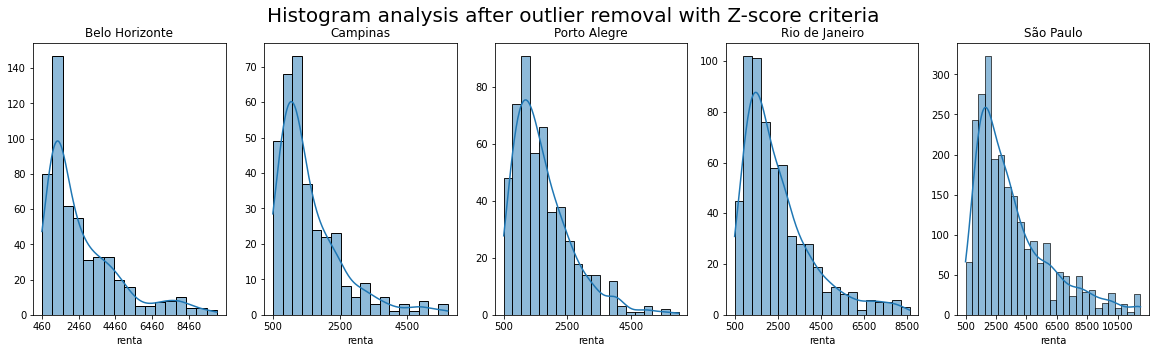

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
cities = new_data_Z['ciudad'].unique()
i = 0
for city in cities:
    ax[i].set_title(city)
    city_name = new_data_Z.loc[new_data_Z['ciudad'] == city]
    sns.histplot(city_name['renta'], ax=ax[i], kde=True)
    ax[i].set_xticks(np.arange(city_name['renta'].min(), city_name['renta'].max(), step=2000))
    ax[i].set_ylabel('')
    i+=1
fig.suptitle('Histogram analysis after outlier removal with Z-score criteria', fontsize=20)

Text(0.5, 0.98, 'Boxplot analysis after outlier removal with IQ criteria')

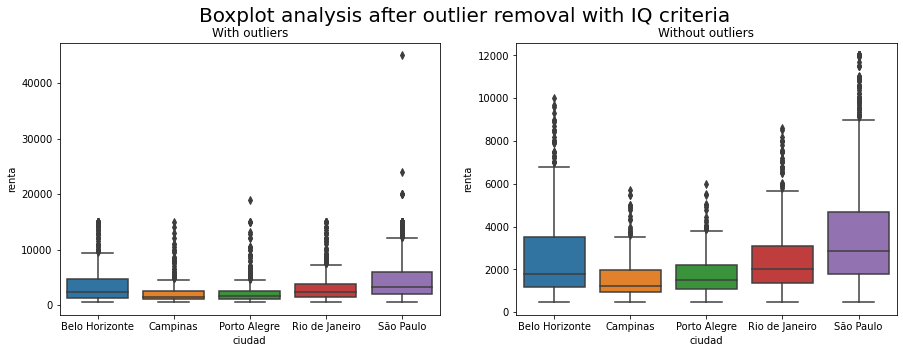

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.boxplot(x=df['ciudad'], y=df['renta'], ax=ax[0])
ax[0].set_title('With outliers')
sns.boxplot(x=new_data_Z['ciudad'], y=new_data_Z['renta'], ax=ax[1])
ax[1].set_title('Without outliers')
fig.suptitle('Boxplot analysis after outlier removal with IQ criteria', fontsize=20)

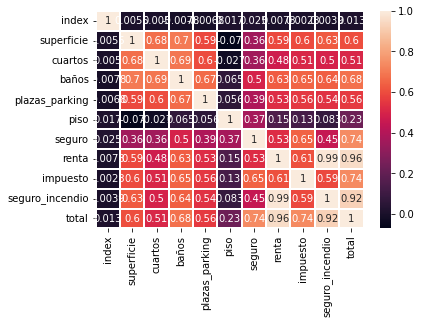

In [20]:
ax = sns.heatmap(new_data_Z.corr(),annot=True,lw=1)

# 5. Training models

## 5.1. Model with variable 'ciudad' one-hot encoded and outliers removed by IQ criteria for numerical variables

In [21]:
keys = ['ciudad','cuartos','baños','plazas_parking']
features = new_data_IQ[keys].copy()
X = pd.get_dummies(features, drop_first=False, dtype=np.float32)
y = new_data_IQ[['renta']].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size =.20, random_state=12345)

Text(0, 0.5, 'predicted')

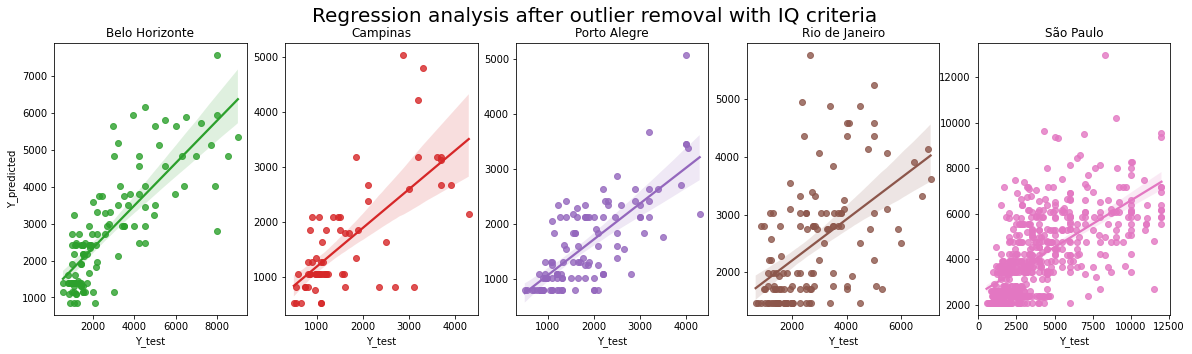

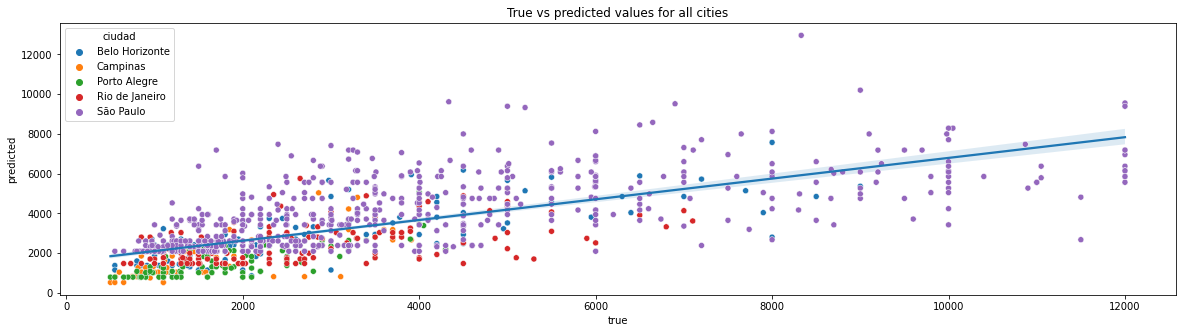

In [22]:
# Fit Linear Regressor
reg1 = linear_model.LinearRegression()
reg1.fit(X_train, Y_train)
Y_predicted = reg1.predict(X_test)
df_pred = pd.DataFrame(
        { 'ciudad': features['ciudad'].iloc[X_test.index].values, 
            'Y_test': Y_test.values.squeeze(),
            'Y_predicted': Y_predicted.squeeze()} )
df_pred = df_pred.sort_values(by='ciudad') 
#
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
cities = df_pred['ciudad'].unique()
i = 0
default_colors = get_cmap('tab10')
for city in cities:
    ax[i].set_title(city)
    sns.regplot(x='Y_test', y='Y_predicted', data=df_pred[df_pred['ciudad']==city], 
                ax=ax[i], color=default_colors(i+2))
    if i!=0:
        ax[i].set_ylabel('')
    i+=1
fig.suptitle('Regression analysis after outlier removal with IQ criteria', fontsize=20)

# Plot true vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
ax.set_title('True vs predicted values for all cities')
sns.regplot(x='Y_test', y='Y_predicted', data=df_pred, scatter=False, ax=ax)
sns.scatterplot(x='Y_test', y='Y_predicted', hue='ciudad', data=df_pred, ax=ax)
# ax.scatter()
ax.set_xlabel('true')
ax.set_ylabel('predicted')


In [23]:
print('MAE:', mean_absolute_error(Y_test, Y_predicted))
print('RMSE:', np.sqrt(mean_squared_error(Y_test, Y_predicted)))
print('R2:', r2_score(Y_test, Y_predicted))

MAE: 1238.846
RMSE: 1757.5394
R2: 0.4863589376608798


## 5.2. Model for variable Porto Alegre city only and outliers removed by IQ criteria for numerical variables 

In [24]:
keys = ['ciudad','cuartos','baños','plazas_parking']
features = new_data_IQ[keys].copy()
y = new_data_IQ[['renta']].copy()
X = features.loc[features['ciudad']=='Porto Alegre']
X = X.drop(['ciudad'], axis=1)
y = y.loc[features['ciudad']=='Porto Alegre']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size =.20, random_state=12345)

Text(0, 0.5, 'predicted')

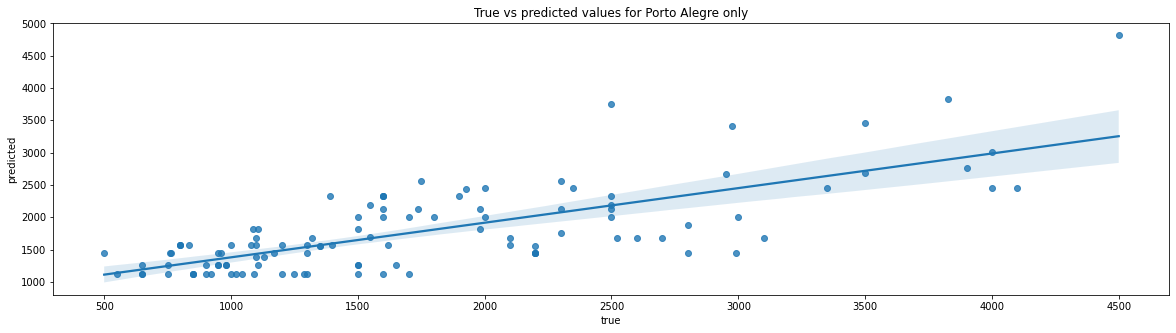

In [25]:
# Fit Linear Regressor
reg2 = linear_model.LinearRegression()
reg2.fit(X_train, Y_train)
Y_predicted = reg2.predict(X_test)

# Plot true vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
ax.set_title('True vs predicted values for Porto Alegre only')
sns.regplot(x=Y_test, y=Y_predicted, scatter=True, ax=ax)
ax.set_xlabel('true')
ax.set_ylabel('predicted')


In [26]:
mae_reg2 = mean_absolute_error(Y_test, Y_predicted)
rmse_reg2 = np.sqrt(mean_squared_error(Y_test, Y_predicted))
Y_predicted_reg2 = Y_predicted
Y_test_reg2 = Y_test
print('MAE:', mean_absolute_error(Y_test, Y_predicted))
print('RMSE:', np.sqrt(mean_squared_error(Y_test, Y_predicted)))
print('R2:', r2_score(Y_test, Y_predicted))

MAE: 500.47552
RMSE: 610.38
R2: 0.538673537840151


## 5.3. Model with variable 'ciudad' one-hot encoded and outliers removed by Z-score criteria for numerical variables

In [27]:
keys = ['ciudad','cuartos','baños','plazas_parking']
features = new_data_Z[keys].copy()
X = pd.get_dummies(features, drop_first=False, dtype=np.float32)
y = new_data_Z[['renta']].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size =.20, random_state=12345)

Text(0, 0.5, 'predicted')

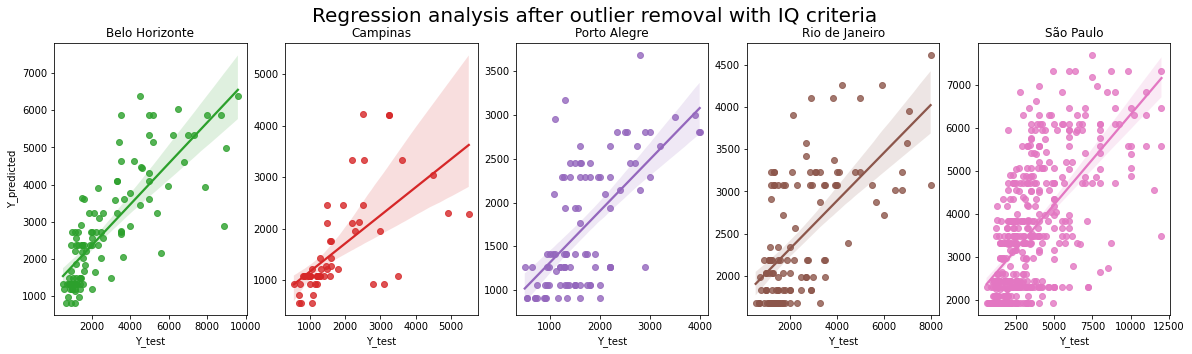

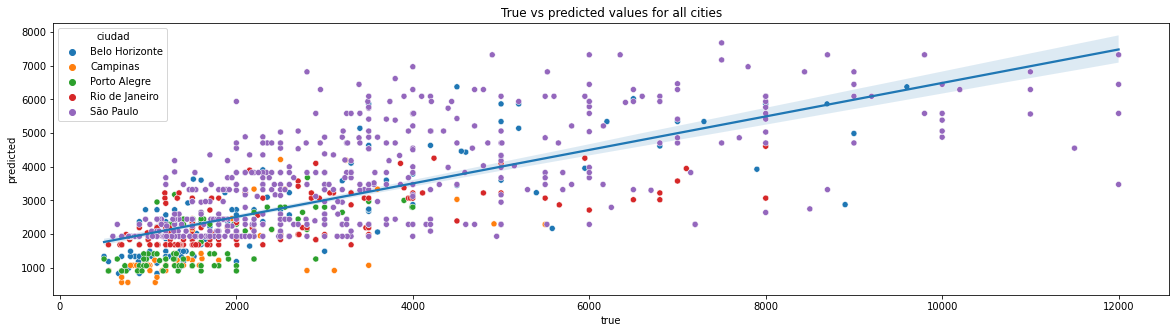

In [28]:
# Fit Linear Regressor
reg3 = linear_model.LinearRegression()
reg3.fit(X_train, Y_train)
Y_predicted = reg3.predict(X_test)
df_pred = pd.DataFrame(
        { 'ciudad': features['ciudad'].iloc[X_test.index].values, 
            'Y_test': Y_test.values.squeeze(),
            'Y_predicted': Y_predicted.squeeze()} )
df_pred = df_pred.sort_values(by='ciudad') 
#
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
cities = df_pred['ciudad'].unique()
i = 0
default_colors = get_cmap('tab10')
for city in cities:
    ax[i].set_title(city)
    sns.regplot(x='Y_test', y='Y_predicted', data=df_pred[df_pred['ciudad']==city], 
                ax=ax[i], color=default_colors(i+2))
    if i!=0:
        ax[i].set_ylabel('')
    i+=1
fig.suptitle('Regression analysis after outlier removal with IQ criteria', fontsize=20)

# Plot true vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
ax.set_title('True vs predicted values for all cities')
sns.regplot(x='Y_test', y='Y_predicted', data=df_pred, scatter=False, ax=ax)
sns.scatterplot(x='Y_test', y='Y_predicted', hue='ciudad', data=df_pred, ax=ax)
# ax.scatter()
ax.set_xlabel('true')
ax.set_ylabel('predicted')

## 5.4. Model for variable Porto Alegre city only and outliers removed by Z-score criteria for numerical variables 

In [29]:
keys = ['ciudad','cuartos','baños','plazas_parking']
features = new_data_Z[keys].copy()
y = new_data_Z[['renta']].copy()
X = features.loc[features['ciudad']=='Porto Alegre']
X = X.drop(['ciudad'], axis=1)
y = y.loc[features['ciudad']=='Porto Alegre']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size =.20, random_state=12345)

Text(0, 0.5, 'predicted')

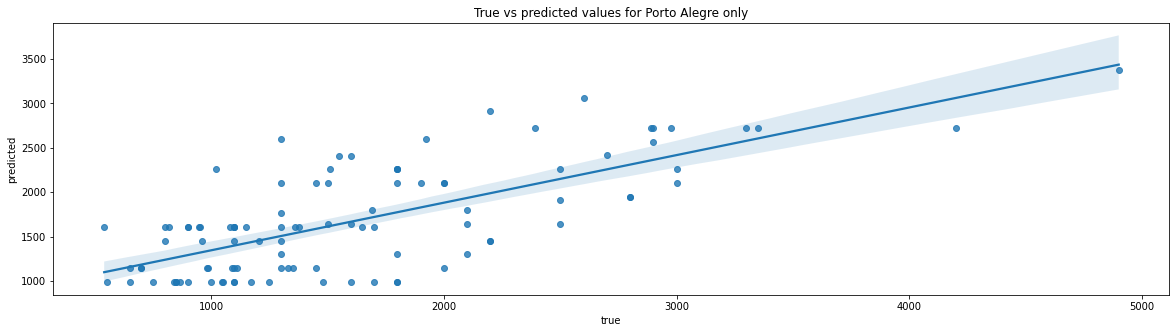

In [30]:
# Fit Linear Regressor
reg4 = linear_model.LinearRegression()
reg4.fit(X_train, Y_train)
Y_predicted = reg4.predict(X_test)

# Plot true vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
ax.set_title('True vs predicted values for Porto Alegre only')
sns.regplot(x=Y_test, y=Y_predicted, scatter=True, ax=ax)
ax.set_xlabel('true')
ax.set_ylabel('predicted')


In [31]:
print('MAE:', mean_absolute_error(Y_test, Y_predicted))
print('RMSE:', np.sqrt(mean_squared_error(Y_test, Y_predicted)))
print('R2:', r2_score(Y_test, Y_predicted))

MAE: 456.98407
RMSE: 562.8918
R2: 0.5063052670320021


## 5.5. Adding variables

### The regressor that only takes into account Porto Belo to train its model and that uses IQ criteria to remove outliers has the best RMSE. Now, we are going to add impuesto and seguro_incendio to the dataset and retrain the model using the setup that produced the best results.  

In [32]:
keys = ['ciudad','cuartos','baños','plazas_parking', 'impuesto', 'seguro_incendio']
features = new_data_IQ[keys].copy()
y = new_data_IQ[['renta']].copy()
X = features.loc[features['ciudad']=='Porto Alegre']
X = X.drop(['ciudad'], axis=1)
y = y.loc[features['ciudad']=='Porto Alegre']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size =.20, random_state=12345)

Text(0, 0.5, 'predicted')

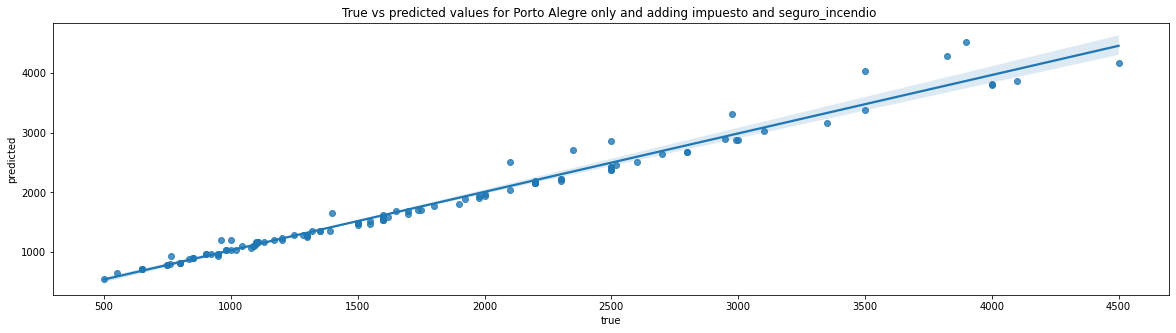

In [33]:
# Fit Linear Regressor
reg5 = linear_model.LinearRegression()
reg5.fit(X_train, Y_train)
Y_predicted = reg5.predict(X_test)

# Plot true vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
ax.set_title('True vs predicted values for Porto Alegre only and adding impuesto and seguro_incendio ')
sns.regplot(x=Y_test, y=Y_predicted, scatter=True, ax=ax)
ax.set_xlabel('true')
ax.set_ylabel('predicted')


In [34]:
Y_test_reg5 = Y_test
Y_predicted_reg5 = Y_predicted
print('MAE:', mean_absolute_error(Y_test, Y_predicted))
print('RMSE:', np.sqrt(mean_squared_error(Y_test, Y_predicted)))
print('R2:', r2_score(Y_test, Y_predicted))

MAE: 86.22845
RMSE: 140.19597
R2: 0.9756623408866003


# Question a)
Viene un cliente que busca un apartamento en Porto Alegre, de
1 o 2 habitaciones con 1 baño y sin parking. ¿Cuál es el monto
mínimo que costaría ese apartamento?

In [35]:
cuartos = 2
baños = 1
plazas_parking = 0
x_query = np.array([cuartos,baños,plazas_parking]).reshape(1,-1)
pred_query = reg2.predict(x_query)[0]
print('costo renta=',pred_query)

costo renta= [1253.06300354]


# Question b)
¿Cuál es el porcentaje de error que se puede esperar del modelo?.
Si consideramos que el error puede hacernos encontrar un
apartamento más barato, ¿Cuál sería el precio mínimo tomando
en cuenta el error?

In [36]:
rmspe = np.sqrt(np.mean(np.square(((Y_test_reg2 - Y_predicted_reg2) / Y_test_reg2)), axis=0))*100
print('El porcentaje de error esperado es: ',rmspe.values[0],'%')
print('El precio mínimo considerando el error es: ',pred_query-rmse_reg2)

El porcentaje de error esperado es:  44.113426 %
El precio mínimo considerando el error es:  [642.68299866]


# Question c)

Añade 2 variables para mejorar el modelo. Con esta mejora, ¿a
cuánto porcentaje de error podemos llegar con nuestra predicción?

In [37]:
rmspe = np.sqrt(np.mean(np.square(((Y_test_reg5 - Y_predicted_reg5) / Y_test_reg5)), axis=0))*100
print('El porcentaje de error esperado con 2 variables añadidas es: ',rmspe.values[0],'%')

El porcentaje de error esperado con 2 variables añadidas es:  6.93515 %
